# Plot census data using geopandas

In [85]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import h3
import shapely
import contextily as cx

In [3]:
zip_f = "zip:////Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/tl_2020_36_tract.zip"

In [4]:
census_geo = gpd.read_file(zip_f)

In [5]:
census_geo.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,+40.6923505,-073.9973434,"POLYGON ((-74.00154 40.69279, -74.00132 40.693..."
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,+40.6917206,-073.9916018,"POLYGON ((-73.99405 40.69090, -73.99374 40.691..."
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,+40.6932903,-073.9877087,"POLYGON ((-73.99073 40.69305, -73.99045 40.693..."


In [6]:
commute = pd.read_csv('nyc/ny_commute_census_tract.csv')
commute = commute.drop(0,axis=0)

In [7]:
commute = commute.rename(columns={"FIPS": "GEOID"})

In [8]:
combined = census_geo.merge(commute, on='GEOID')

In [9]:
combined.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Workers 16 Years and Over: Did Not Work At Home,Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes,Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes,Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes,Workers 16 Years and Over: Worked At Home.1,Average Commute to Work (In Min)
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,...,1884,132,165,316,632,481,39,119,303,36
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,...,2627,181,565,494,751,545,25,66,613,29
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,...,1039,30,222,191,297,196,47,56,151,32


In [28]:
METRIC_COL = 'Average Commute to Work (In Min)'

<AxesSubplot:>

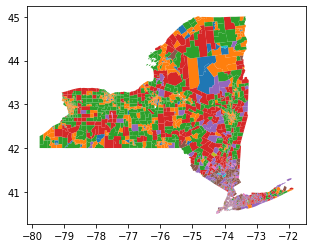

In [10]:
combined.plot(column = 'Average Commute to Work (In Min)')

In [107]:
counties = ['061','081','005','047','085']
nyc = combined[combined['COUNTYFP'].isin(counties)]

In [108]:
nyc = nyc[['geometry','Average Commute to Work (In Min)']]

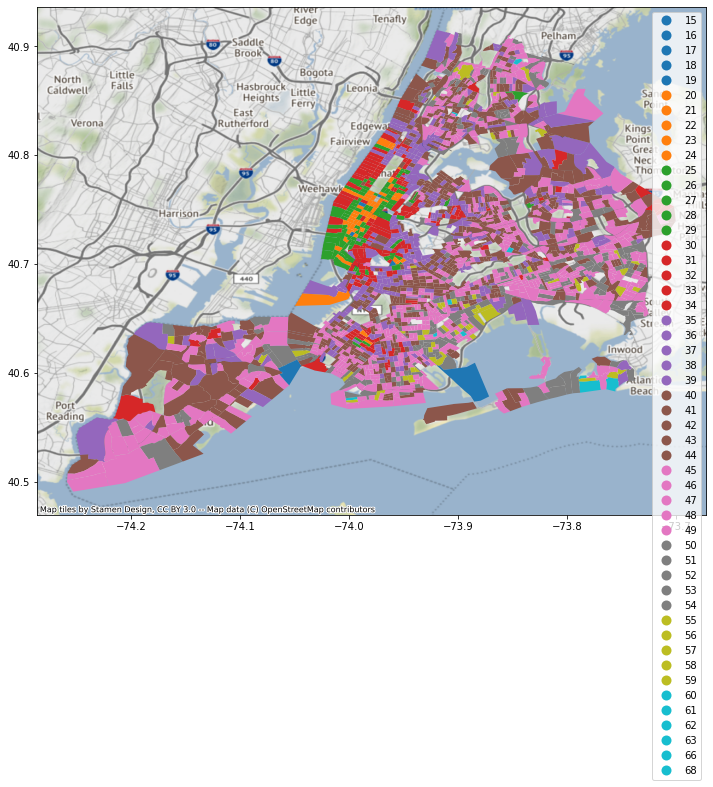

In [115]:
fig, ax = plt.subplots(1, figsize=(12,12))
nyc.plot(column=METRIC_COL,ax=ax,legend=True)
cx.add_basemap(crs="EPSG:4269",ax=ax)

In [118]:
nyc = nyc.reset_index()

In [119]:
# convert shapes to hex bins
APERTURE_SIZE = 10
hex_col = 'hex'+str(APERTURE_SIZE)

poly = type(shapely.geometry.polygon.Polygon())

l = []
for x in range(len(nyc)):
    
    if type(nyc.geometry[x])!=poly:
        l.append(-1)
        
    else:
        hex_bins = h3.polyfill(nyc.geometry[x].__geo_interface__,
                                9,
                                geo_json_conformant = True)
        l.append(hex_bins)

In [120]:
nyc[hex_col] = l

In [121]:
nyc=nyc[nyc[hex_col]!=-1]

In [122]:
len(nyc)

2326

In [123]:
nyc = nyc.explode(hex_col).reset_index()

In [124]:
nyc = nyc[~nyc[hex_col].isnull()]

In [125]:
# add lat & lng of center of hex 
nyc['lat']=nyc[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
nyc['lng']=nyc[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# create Point object based on hex latlng
nyc['geometry'] = nyc.apply(lambda x: shapely.geometry.Point(x.lng,x.lat),1)
nyc.crs = {"init": "epsg:4326"}

/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [127]:
nyc = nyc[~nyc[METRIC_COL].isnull()]
nyc[METRIC_COL] = nyc[METRIC_COL].astype('int')

In [128]:
nyc

,level_0,index,geometry,Average Commute to Work (In Min),hex10,lat,lng
0,0,0,POINT (-73.99627 40.69149),36,892a107298bffff,40.691495,-73.996265
1,1,1,POINT (-73.99199 40.69161),29,892a1072983ffff,40.691611,-73.991995
2,2,2,POINT (-73.98772 40.69173),32,892a1072997ffff,40.691727,-73.987724
3,2,2,POINT (-73.98996 40.69431),32,892a1072993ffff,40.694308,-73.989963
4,2,2,POINT (-73.98569 40.69442),32,892a1072d2fffff,40.694424,-73.985692
...,...,...,...,...,...,...,...
11664,2325,5409,POINT (-73.77159 40.68417),51,892a1005a6fffff,40.684172,-73.771593
11665,2326,5410,POINT (-73.77364 40.68148),44,892a103b4d7ffff,40.681479,-73.773636
11666,2326,5410,POINT (-73.77586 40.68406),44,892a103b4d3ffff,40.684064,-73.775863
11667,2326,5410,POINT (-73.78013 40.68396),44,892a103b4dbffff,40.683956,-73.780132


In [138]:
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):
    fig, ax = plt.subplots(1, figsize=(12, 12))
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize,
                    ax=ax,s=50);
    plt.xticks([], []); plt.yticks([], [])
    cx.add_basemap(crs="EPSG:4326",ax=ax)

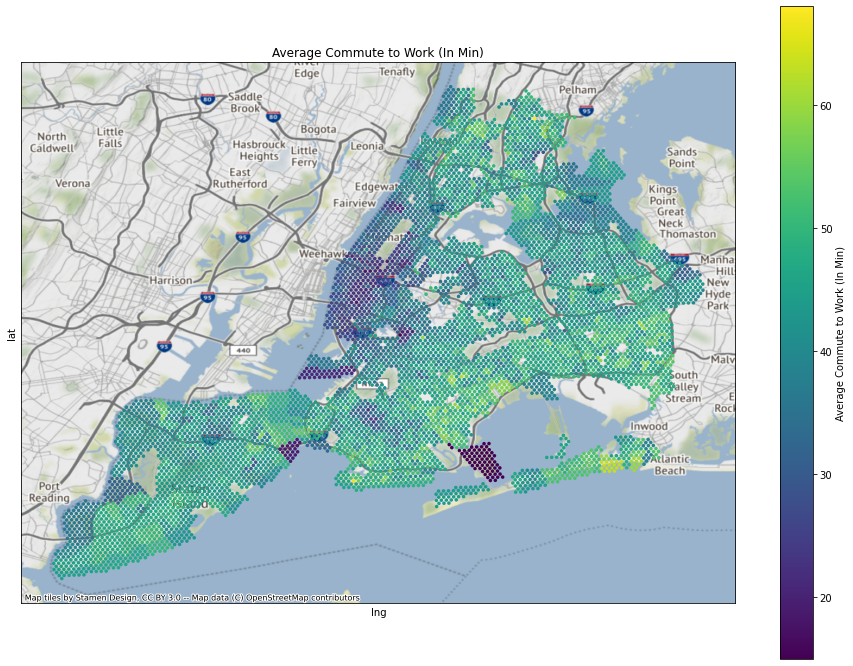

In [139]:
plot_scatter(pd.DataFrame(nyc), metric_col=METRIC_COL, marker='.')

<AxesSubplot:>

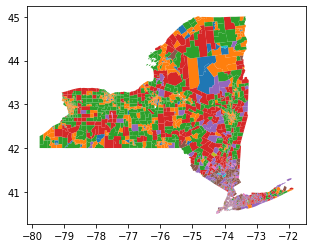

In [106]:
combined.plot(column=METRIC_COL)